In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Smiles2Mol, Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local, computeChemicalValidityAndNovelty, parseChempropAtomFeatures, parseChempropBondFeatures
from dfs_transformer.utils import FeaturizedDFSCodes2Nx, Mol2Nx, Nx2Mol
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm
import traceback

2022-01-19 18:30:41.689120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

In [2]:
pretrained_model = "r2r-nofeat-c4s-noprop"#"r2r-nofeat-entrywise2-c4s-noprop"
pretrained_model = "r2r-entrywise2-c4s"
pretrained_project = "pubchem_newdataloader"
pretrained_project = "pubchem_postbug"
#pretrained_model = "r2r-2K"
force_download = False
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model) and not force_download:
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb", pretrained_project=pretrained_project)

In [3]:
bert = bert.eval()

In [4]:
with open("../../config/selfattn/data/pubchem10K.yaml") as file:
    d = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
cfg.training.fraction_missing = 0.

In [6]:
d.no_features = cfg.data.no_features

In [7]:
if cfg.training.mode == "rnd2rnd":
    collate_fn = functools.partial(dfs.collate_BERT, 
                                   mode=cfg.training.mode, 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)
elif cfg.training.mode == "rnd2rnd_entry":
    collate_fn = functools.partial(dfs.collate_BERT_entries, 
                                   mode="rnd2rnd", 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)

In [8]:
validset = dfs.PubChem('../.'+d.valid_path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs,
                   filter_unencoded=False)
validloader = DataLoader(validset, batch_size=100, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=4,
                         prefetch_factor=2)

100%|█████████████████████████████████████| 9978/9978 [00:05<00:00, 1681.31it/s]


In [9]:
data = next(iter(validloader))

In [47]:
graphs = FeaturizedDFSCodes2Nx(data[0])

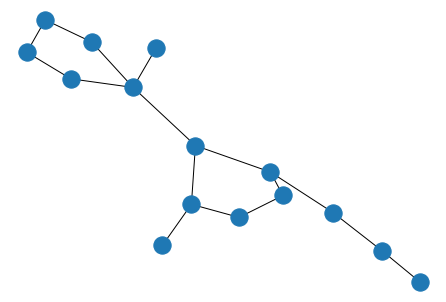

In [53]:
import networkx as nx
nx.draw(graphs[5])

In [69]:
data[0]['bnd'][:, 0]

tensor([[    0.,     0.,     1.,     0.,     0.,     1.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     1.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     1.,     1.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     1.,     1.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     1.,     1.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     1.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
  

In [72]:
ATOM_FEATURES = {
    'atomic_num': list(range(1, 100+1)),
    'degree': [0, 1, 2, 3, 4, 5],
    'formal_charge': [-1, -2, 1, 2, 0],
    'chiral_tag': [Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
                   Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
                   Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
                   Chem.rdchem.ChiralType.CHI_OTHER],
    'num_Hs': [0, 1, 2, 3, 4],
    'hybridization': [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

In [76]:
len(ATOM_FEATURES['atomic_num'])

100

In [71]:
data[0]['atm_from'][:, 0][:, 119:119+6]

tensor([[    1.,     0.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     1.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    1.,     0.,     0.,     0.,     0.,     0.],
        [    1

In [58]:
nx.get_node_attributes(graphs[0], 'atomic_num')

{0: 6,
 1: 16,
 2: 6,
 3: 6,
 4: 6,
 5: 6,
 6: 7,
 7: 6,
 8: 6,
 9: 6,
 10: 6,
 11: 6,
 12: 6,
 13: 6,
 14: 35,
 15: 6,
 16: 6,
 17: 6,
 18: 6,
 19: 7}

In [59]:
nx.get_node_attributes(graphs[0], 'hybridization')

{0: rdkit.Chem.rdchem.HybridizationType.SP2,
 1: rdkit.Chem.rdchem.HybridizationType.SP2,
 2: rdkit.Chem.rdchem.HybridizationType.SP2,
 3: rdkit.Chem.rdchem.HybridizationType.SP2,
 4: rdkit.Chem.rdchem.HybridizationType.SP2,
 5: rdkit.Chem.rdchem.HybridizationType.SP2,
 6: rdkit.Chem.rdchem.HybridizationType.SP2,
 7: rdkit.Chem.rdchem.HybridizationType.SP3,
 8: rdkit.Chem.rdchem.HybridizationType.SP2,
 9: rdkit.Chem.rdchem.HybridizationType.SP2,
 10: rdkit.Chem.rdchem.HybridizationType.SP2,
 11: rdkit.Chem.rdchem.HybridizationType.SP2,
 12: rdkit.Chem.rdchem.HybridizationType.SP2,
 13: rdkit.Chem.rdchem.HybridizationType.SP2,
 14: rdkit.Chem.rdchem.HybridizationType.SP3,
 15: rdkit.Chem.rdchem.HybridizationType.SP3,
 16: rdkit.Chem.rdchem.HybridizationType.SP2,
 17: rdkit.Chem.rdchem.HybridizationType.SP2,
 18: rdkit.Chem.rdchem.HybridizationType.SP3,
 19: rdkit.Chem.rdchem.HybridizationType.SP2}

In [57]:
nx.get_node_attributes(graphs[0], 'num_total_hs')

{0: 0,
 1: 0,
 2: 0,
 3: 1,
 4: 1,
 5: 0,
 6: 0,
 7: 2,
 8: 0,
 9: 1,
 10: 1,
 11: 0,
 12: 1,
 13: 1,
 14: 0,
 15: 3,
 16: 0,
 17: 1,
 18: 3,
 19: 2}

In [80]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)

    Chem.SanitizeMol(mol)
    return mol


In [87]:
mol = Chem.MolFromSmiles(smiles1)
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

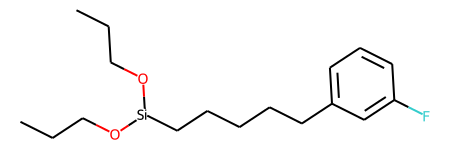

In [88]:
mol

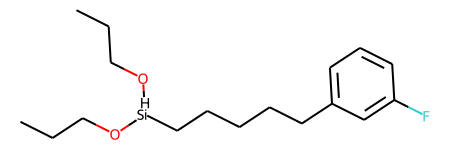

In [85]:
nx_to_mol(mol_to_nx(Chem.MolFromSmiles(smiles1)))

In [82]:
smiles1 = 'CCCO[Si](CCCCCc1cccc(F)c1)OCCC'
smiles2 = Chem.MolToSmiles(nx_to_mol(mol_to_nx(Chem.MolFromSmiles(smiles1))))
print(smiles1)
print(smiles2)
print(smiles1 == smiles2)

CCCO[Si](CCCCCc1cccc(F)c1)OCCC
CCCO[SiH](CCCCCc1cccc(F)c1)OCCC
False


In [89]:
bad_smiles = []
for dd, graph in zip(validset[:100], graphs):
    try:
        smiles1 = Chem.MolToSmiles(Chem.MolFromSmiles(dd.smiles))
        print(smiles1)
        mol = Nx2Mol(graph)
        smiles2 = Chem.MolToSmiles(mol)
        print(smiles2)
        assert smiles1 == smiles2
    except:
        bad_smiles += [smiles1]

Cc1cc(C(N)=S)ccc1N(C)Cc1ccc(Br)cc1
Cc1cc(C(N)=S)ccc1N(C)Cc1ccc(Br)cc1
CC=C(C(=CC)N(CC)C(=O)c1ccco1)C1CC1
CC=C(C(=CC)N(CC)C(=O)c1ccco1)C1CC1
NNC(Cc1ccc(F)cc1F)c1cnsn1
NNC(Cc1ccc(F)cc1F)c1cnsn1
COC(=O)c1ccc(N2C(=O)C(O)=C(c3cc(Cl)c(OC)c(Cl)c3)C2c2sccc2C)cc1
COC(=O)c1ccc(N2C(=O)C(O)=C(c3cc(Cl)c(OC)c(Cl)c3)C2c2sccc2C)cc1
CCc1c[nH+]c(SCC(=O)[O-])n1CCCCC(N)=O
CCc1c[nH+]c(SCC(=O)[O-])n1CCCCC(N)=O
CCCc1n[nH]c(=S)n1C1(C)CCOC1
CCCc1n[nH]c(=S)n1C1(C)CCOC1
O=C(c1ccc(S(=O)(=O)N2CCOCC2)cc1)N(CCn1cccn1)c1nc2ccc(F)cc2s1
O=C(c1ccc(S(=O)(=O)N2CCOCC2)cc1)N(CCn1cccn1)c1nc2ccc(F)cc2s1
O=[N+]([O-])c1ccc(-c2noc(CCn3cc(Br)cn3)n2)cc1
O=[N+]([O-])c1ccc(-c2noc(CCn3cc(Br)cn3)n2)cc1
O=C1OP2(=O)NC12Cc1cnc[nH]1
O=C1OP2(=O)NC12Cc1cnc[nH]1
Cc1ccc(NC(=O)C(NC(=O)C2CC[NH+](CC(=O)Nc3cccc(C(=O)N(C)C)c3C)CC2)C(C)C)cc1NC(=O)Cc1ccc(F)cc1
Cc1ccc(NC(=O)C(NC(=O)C2CC[NH+](CC(=O)Nc3cccc(C(=O)N(C)C)c3C)CC2)C(C)C)cc1NC(=O)Cc1ccc(F)cc1
CC(C)(C)CCc1cc(O)c(C(=O)NCC(=O)[O-])n2ncnc12
CC(C)(C)CCc1cc(O)c(C(=O)NCC(=O)[O-])n2ncnc12
Cc1ccc(OC(

In [90]:
bad_smiles

['CCCO[Si](CCCCCc1cccc(F)c1)OCCC']

In [21]:
atom_feats = parseChempropAtomFeatures(data[0]['atm_from'], true_values=True)

In [22]:
atom_feats

{'atomic_num': array([[6, 7, 16, ..., 8, 6, 7],
        [6, 6, 7, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=object),
 'degree': array([[3, 3, 2, ..., 1, 4, 3],
        [3, 3, 2, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=object),
 'formal_charge': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000],
        [-1000, -1000, -1000, ..., -1000, -1000, -1000]], dtype=object),
 'chiral_tag': array([[rdkit.Chem.rdchem.ChiralType.CHI_UNSPE

In [9]:
device = torch.device('cuda:%d'%0 if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
to_cuda = functools.partial(dfs.utils_to_cuda, device=device)

In [10]:
bert = bert.to(device)

In [11]:
smiles = [data.smiles for data in validset]
codes = [data.min_dfs_code.numpy().tolist() for data in validset]
print(computeChemicalValidityAndNovelty(smiles, codes))

(1.0, 1.0)


In [12]:
valid_list = []
same_list = []
for code, sml in zip(codes, smiles):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except:
        valid_list += [False]
    try:
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(sml))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if not same_list[-1]:
                print(smiles_orig)
                print(smiles_rec)
                print("--------------------")
    except:
        continue
valid = np.asarray(valid_list)
same = np.asarray(same_list)


In [13]:
dfs_codes = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes += bert.fwd_code(data[0], data[1], features=not cfg.data.no_features)
valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

  0%|                                                    | 0/51 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|███████████████████████████████████████████| 51/51 [00:06<00:00,  8.47it/s]


0.9921 valid molecules
0.8870 of the valid molecules stayed the same


In [14]:
dfs_codes = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes += bert.fwd_code_sample(data[0], data[1], features=not cfg.data.no_features)
valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

  0%|                                                    | 0/51 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|███████████████████████████████████████████| 51/51 [00:05<00:00,  9.32it/s]


0.9889 valid molecules
0.8489 of the valid molecules stayed the same


In [15]:
smiles = [data.smiles for data in validset]

In [16]:
dfs_codes2 = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes2 += bert.fwd_code_all(data[0])

valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes2, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

  0%|                                                    | 0/51 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|███████████████████████████████████████████| 51/51 [00:05<00:00,  8.59it/s]


0.9795 valid molecules
0.8555 of the valid molecules stayed the same


In [17]:
dfs_codes2 = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes2 += bert.fwd_code_all_sample(data[0])

valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes2, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

  0%|                                                    | 0/51 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|███████████████████████████████████████████| 51/51 [00:05<00:00,  8.82it/s]


0.9570 valid molecules
0.7443 of the valid molecules stayed the same


/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


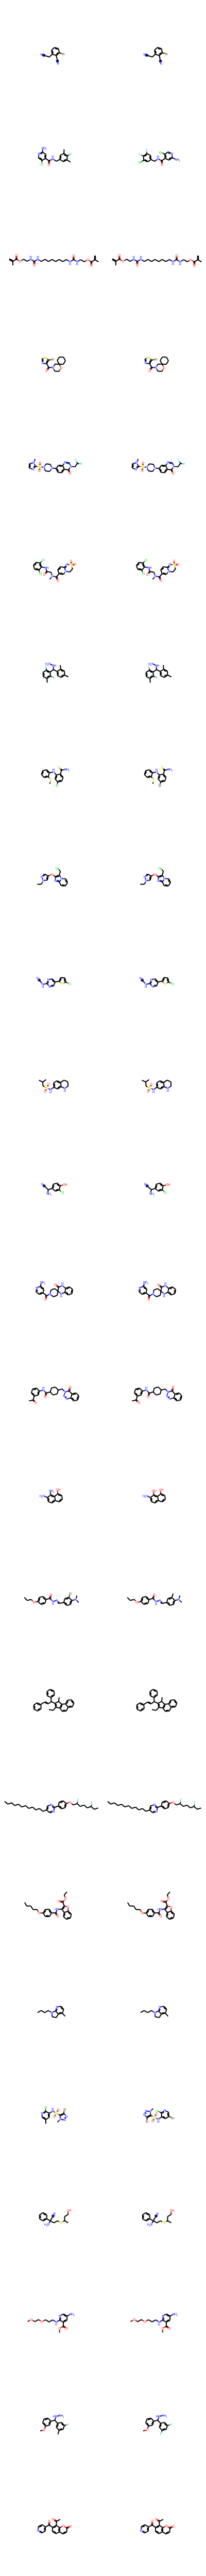

In [18]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

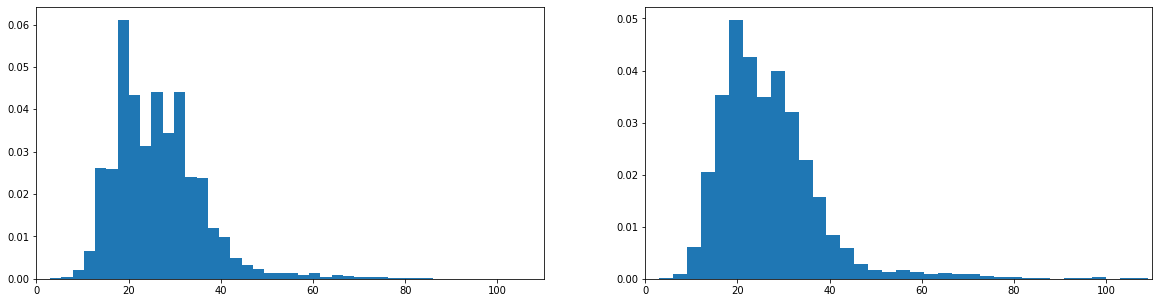

In [19]:
from matplotlib import pyplot as plt
lens = np.asarray([len(dfs_code) for dfs_code in dfs_codes])
plt.figure(figsize=(20,5))
plt.subplot(1,2,1).hist(lens[valid], bins='rice', density=True)
plt.xlim(0, 110)
plt.subplot(1,2,2).hist(lens, bins='rice', density=True)
plt.xlim(0, 110)
plt.show()